In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
from scipy.stats import poisson
import seaborn as sns
from scipy.interpolate import PchipInterpolator

import matplotlib as mpl
mpl.style.use('../note_plot_style.mplstyle')

## Sensitivity Monte Carlo for counting experiment

This notebook is a very simple toy monte carlo to calculate sensitivity and discovery potential for a counting experiment. Start with some function definitions

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def bg_trials(bg_means, n_trials):
    return np.random.poisson(lam=bg_means, size=(n_trials, bg_means.size))

def signal_trials(sig_means, n_trials):
    return np.random.poisson(lam=sig_means, size=(n_trials, sig_means.size))

def total_trials(bg_means, sig_means, n_trials):
    bg = bg_trials(bg_means, n_trials)
    sig = signal_trials(sig_means, n_trials)
    total = bg[:,:,np.newaxis] + sig[:,np.newaxis]
    return total, bg, sig

def calc_thresh_frac(bg_means, sig_lams, n_trials, thresh_percent=50., thresh_cl=0.9):
    bg = bg_trials(bg_means, n_trials)
    tot, bg, sig = total_trials(bg_lams, sig_lams, n_trials)
    thresh = np.percentile(bg, thresh_percent, axis=0)
    sig_fracs = np.count_nonzero(
        tot > thresh[:,np.newaxis],
        axis=0) / n_trials
    spls = [PchipInterpolator(sig_lams, frac - thresh_cl) for frac in sig_fracs]
    sens = [spl.roots() for spl in spls]
    sens = [x[(x>sig_lams[0]) & (x < sig_lams[-1])][0] for x in sens]
    return sens

@np.vectorize
def sens_quasi_analytical(bg_lam, sig_max=100, cdf_val=0.5):
    xvals = np.linspace(0., sig_max, sig_max + 1)
    fine_scale_fac = 10
    fine_x_vals = np.linspace(0., sig_max, sig_max * fine_scale_fac)
    median = np.min(np.argwhere(poisson.cdf(xvals, bg_lam) > cdf_val))
    test_strengths = sp.special.gammaincc(median + 1, fine_x_vals)
    ind = find_nearest(test_strengths, 1./fine_scale_fac)
    sens_analytical = fine_x_vals[ind] - bg_lam
    return sens_analytical

Next, run the monte carlo, and calculate the sensitivity as a function of the background rate. Also compare this to the expectation from a non-monte carlo approach

In [4]:
sig_lams = np.linspace(0., 13., 100)
bg_lams = np.append(np.logspace(-5., -1., 35), np.linspace(.2, 10, 80))
ntrials = 10000

sensitivity = calc_thresh_frac(
    bg_lams, 
    sig_lams, 
    ntrials, 
    thresh_percent=50.,
    thresh_cl=0.9
    )

sens_analytical = sens_quasi_analytical(bg_lams)

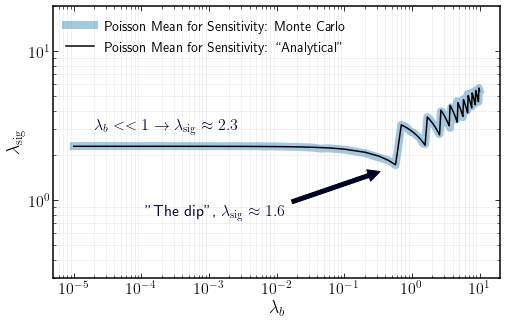

In [5]:
fig, ax = plt.subplots(figsize = (8,5))
fig.set_facecolor('w')

plt.plot(bg_lams, sensitivity, 
         lw=8., label='Poisson Mean for Sensitivity: Monte Carlo', alpha = 0.4)
plt.plot(bg_lams, sens_analytical, 
         c = 'k', label= 'Poisson Mean for Sensitivity: ``Analytical"')

plt.text(2e-5, 3., 
         r'$\lambda_b << 1 \rightarrow \lambda_{\mathrm{sig}}\approx 2.3$',
         color=sns.xkcd_rgb['dark navy blue'])
ax.annotate(r'"The dip", $\lambda_{\mathrm{sig}}\approx 1.6$',
            color=sns.xkcd_rgb['dark navy blue'],
            xy=(0.4, 1.6), xycoords='data',
            xytext=(-1e2, -5e1), textcoords='offset points',
            arrowprops=dict(facecolor=sns.xkcd_rgb['dark navy blue'], shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

plt.loglog()
plt.ylim(3e-1, 2e1)
plt.legend(loc=2, fontsize=14, frameon=False)
plt.xlabel(r'$\lambda_{b}$', fontsize = 18)
plt.ylabel(r'$\lambda_{\mathrm{sig}}$', fontsize = 18)
plt.grid(which = 'both', alpha = 0.4)

plt.show()

Now, we do the same for discovery potential, but for two different confidence levels to highlight the "flip-flop" phenomenon

In [6]:
discovery_3sig_50 = calc_thresh_frac(
    bg_lams, 
    sig_lams, 
    ntrials, 
    thresh_percent=99.865,
    thresh_cl=0.5
    )
discovery_3sig_90 = calc_thresh_frac(
    bg_lams[:10], 
    np.linspace(1., 25, 200), 
    ntrials, 
    thresh_percent=99.865,
    thresh_cl=0.9
    )

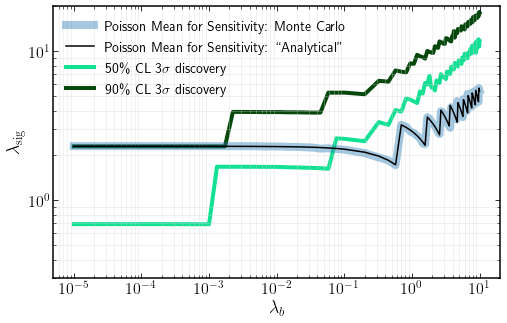

In [7]:
fig, ax = plt.subplots(figsize = (8,5))
fig.set_facecolor('w')

plt.plot(bg_lams, sensitivity, 
         lw=8., label='Poisson Mean for Sensitivity: Monte Carlo', alpha = 0.4)
plt.plot(bg_lams, sens_analytical, 
         c = 'k', label= 'Poisson Mean for Sensitivity: ``Analytical"')
plt.plot(bg_lams, discovery_3sig_50, 
         lw=4., c = sns.xkcd_rgb['aqua green'], 
         label = r'50\% CL 3$\sigma$ discovery', zorder=1)
plt.plot(bg_lams, discovery_3sig_90, 
         lw=4., c = sns.xkcd_rgb['forest green'], 
         label = r'90\% CL 3$\sigma$ discovery', zorder=1)

plt.loglog()
plt.ylim(3e-1, 2e1)
plt.legend(loc=2, fontsize=14, frameon=False)
plt.xlabel(r'$\lambda_{b}$', fontsize = 18)
plt.ylabel(r'$\lambda_{\mathrm{sig}}$', fontsize = 18)
plt.grid(which = 'both', alpha = 0.4)

plt.show()